In [14]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
from collections import OrderedDict

%matplotlib inline

In [17]:
#download the pretrained model
import torchvision.models as models
#model = models.vgg16(pretrained = True) # to little VRAM to work 
#model = models.googlenet(pretrained = True)
#model = models.mobilenet_v2(pretrained = True)
model = models.resnet18(pretrained = True)
#model = models.densenet121(pretrained=True)

#switch device to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', torch.cuda.get_device_name(torch.cuda.current_device()))
print('Cuda available:', torch.cuda.is_available(), '\n')

import GPUtil
GPUtil.showUtilization()

Device: GeForce MX110
Cuda available: True 

| ID | GPU | MEM |
------------------
|  0 |  0% | 26% |


In [18]:
#model layers
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# Freeze model parameters 
for param in model.parameters():
    param.requires_grad = False 

In [21]:
#upgrading model
'''fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1000,512)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(512,2)),
    ('output', nn.LogSoftmax(dim = 1))
]))
'''
model.fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,256)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(256,2)),
    ('output', nn.LogSoftmax(dim = 1))
    ]))

del model.fc

In [22]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
def load_data(data_folder, batch_size, num_workers):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.ColorJitter(),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(128),
        transforms.ToTensor()
    ])
    
    data = torchvision.datasets.ImageFolder(root = data_folder, transform = transform)
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers = num_workers)
    return data_loader 

In [24]:
data_folder = 'D:\\Python\\Cats and dogs\\Data\\train'
batch_size = 24
num_workers = 0
dataloader = load_data(data_folder, batch_size, num_workers)

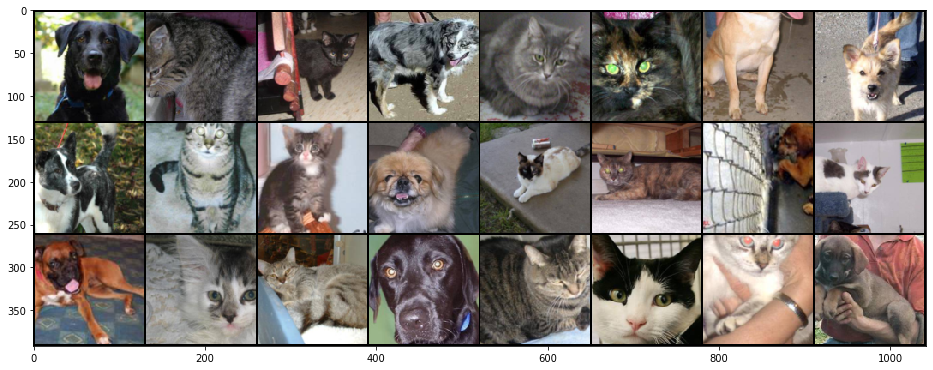

In [25]:
samples, labels = iter(dataloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [26]:
#shifting model to gpu
model = model.to(device)
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 26% |


[Epoch 1/3] Iteration 200 -> Train Loss: 0.2600, Accuracy: 0.875
[Epoch 1/3] Iteration 400 -> Train Loss: 0.2020, Accuracy: 0.958
[Epoch 1/3] Iteration 600 -> Train Loss: 0.2050, Accuracy: 0.875
[Epoch 1/3] Iteration 800 -> Train Loss: 0.1875, Accuracy: 0.875
[Epoch 1/3] Iteration 1000 -> Train Loss: 0.1840, Accuracy: 0.833
[Epoch 2/3] Iteration 1200 -> Train Loss: 0.1809, Accuracy: 1.000
[Epoch 2/3] Iteration 1400 -> Train Loss: 0.1794, Accuracy: 0.958
[Epoch 2/3] Iteration 1600 -> Train Loss: 0.1855, Accuracy: 0.958
[Epoch 2/3] Iteration 1800 -> Train Loss: 0.1654, Accuracy: 0.833
[Epoch 2/3] Iteration 2000 -> Train Loss: 0.1656, Accuracy: 0.833
[Epoch 3/3] Iteration 2200 -> Train Loss: 0.1641, Accuracy: 0.958
[Epoch 3/3] Iteration 2400 -> Train Loss: 0.1748, Accuracy: 0.917
[Epoch 3/3] Iteration 2600 -> Train Loss: 0.1739, Accuracy: 0.958
[Epoch 3/3] Iteration 2800 -> Train Loss: 0.1663, Accuracy: 0.958
[Epoch 3/3] Iteration 3000 -> Train Loss: 0.1619, Accuracy: 0.958


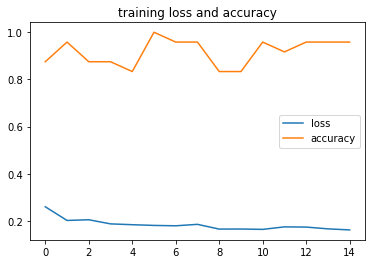

In [27]:
epochs = 3
itr = 1
p_itr = 200
model.train()
total_loss = 0
loss_list = []
acc_list = []
for epoch in range(epochs):
    #total_loss =0
    for samples, labels in dataloader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        scheduler.step() 
        
        if itr%p_itr == 0:
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, acc))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss = 0
        
            
        itr += 1

plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()

In [28]:
test_dir = 'D:\\Python\\Cats and dogs\\Data\\test'
test_files = os.listdir(test_dir)

In [29]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

In [30]:
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 24, shuffle=False, num_workers=0)

In [31]:
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"id":fn_list, "label":pred_list})
#submission.to_csv('preds_densenet121.csv', index=False)

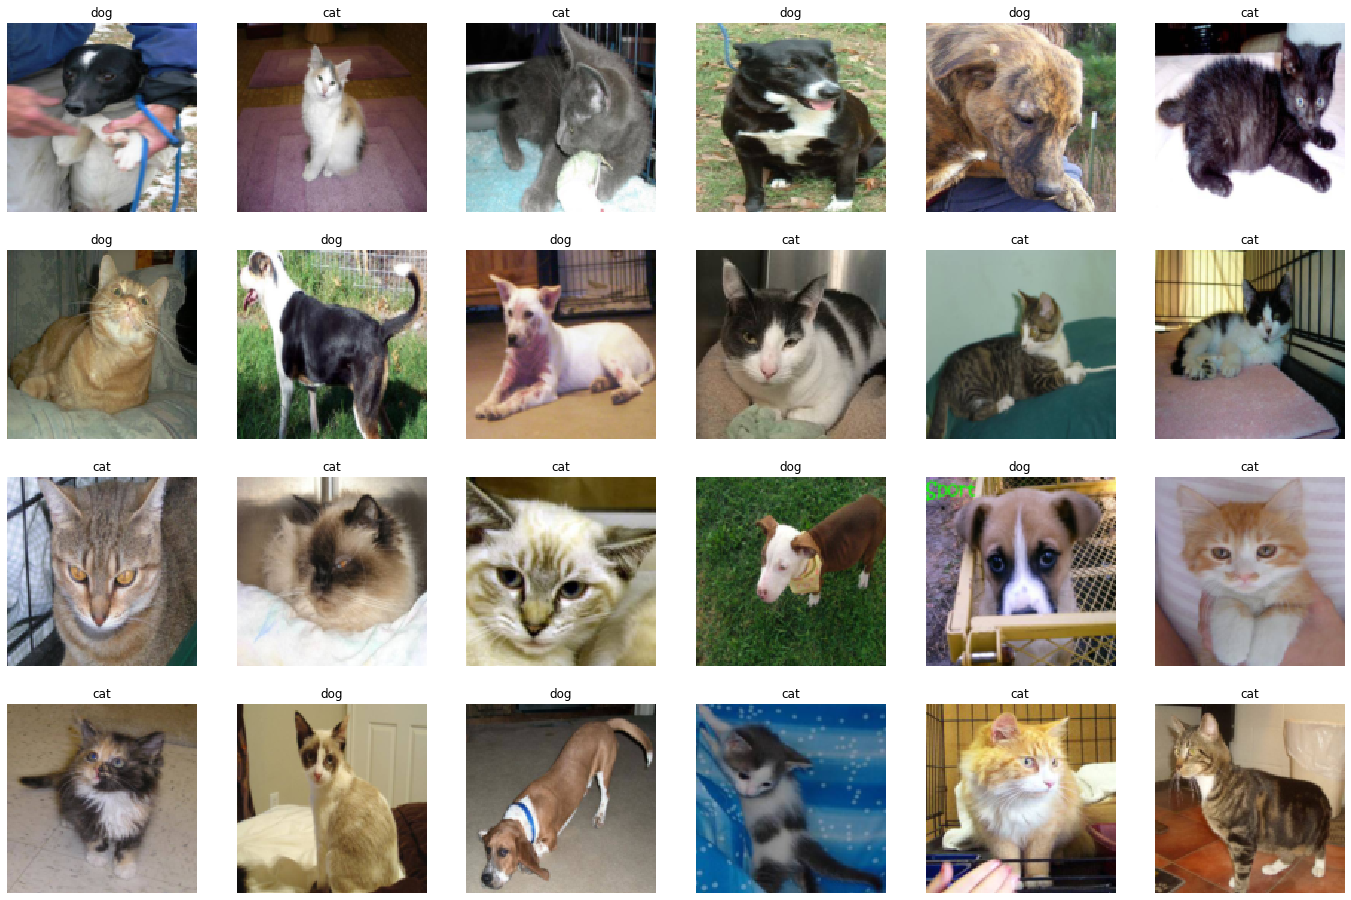

In [18]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))